# Testing dataset

## FIle information
#### book_[train/test].parquet
**stock_id** - ID code for the stock. Not all stock IDs exist in every time bucket. Parquet coerces this column to the categorical data type when loaded; you may wish to convert it to int8. <br>
**time_id** - ID code for the time bucket. Time IDs are not necessarily sequential but are consistent across all stocks.<br>
**seconds_in_bucket** - Number of seconds from the start of the bucket, always starting from 0.<br>
**bid_price[1/2]** - Normalized prices of the most/second most competitive buy level.<br>
**ask_price[1/2]** - Normalized prices of the most/second most competitive sell level.<br>
**bid_size[1/2]** - The number of shares on the most/second most competitive buy level.<br>
**ask_size[1/2]** - The number of shares on the most/second most competitive sell level.<br>

#### trade_[train/test].parquet
Contains data on trades that actually executed.
**stock_id** - Same as above.<br>
**time_id** - Same as above.<br>
**seconds_in_bucket** - Same as above. Note that since trade and book data are taken from the same time window and trade data is more sparse in general, this field is not necessarily starting from 0.<br>
**price** - The average price of executed transactions happening in one second. Prices have been normalized and the average has been weighted by the number of shares traded in each transaction.<br>
**size** - The sum number of shares traded.<br>
**order_count** - The number of unique trade orders taking place.<br>

#### train.csv 
The ground truth values for the training set.
**stock_id** - Same as above, but since this is a csv the column will load as an integer instead of categorical.<br>
**time_id** - Same as above.<br>
**target** - The realized volatility computed over the 10 minute window following the feature data under the same stock/time_id. There is no overlap between feature and target data. You can find more info in our tutorial notebook.<br>

#### test.csv 
Provides the mapping between the other data files and the submission file. As with other test files, most of the data is only available to your notebook upon submission with just the first few rows available for download.
**stock_id** - Same as above.<br>
**time_id** - Same as above.<br>
**row_id** - Unique identifier for the submission row. There is one row for each existing time ID/stock ID pair. Each time window is not necessarily containing every individual stock.<br>

#### sample_submission.csv 
A sample submission file in the correct format.
**row_id** - Same as in test.csv.<br>
**target** - Same definition as in train.csv. The benchmark is using the median target value from train.csv.<br>

## Reading .parquet file

In [3]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
print('current path', os.getcwd())
%cd ..
stock_id = 0
time_id = 5
# set path
root = 'data'#'C:/Users/Darkblade/Documents/Kaggle/dataset/RealizedVolPrediction/'#book_test.parquet'
book_path = glob.glob(f'{root}/book_train.parquet/stock_id={stock_id}/*')
print(book_path)
trade_path =  glob.glob(f'{root}/trade_train.parquet/stock_id={stock_id}/*')

# read file (book and trade dataset)
dfBook = pd.read_parquet(book_path[0])
dfBook = dfBook[dfBook.time_id==time_id]
display(dfBook.head())

dfTrade = pd.read_parquet(trade_path[0])
dfTrade = dfTrade[dfTrade.time_id==time_id]
display(dfTrade.head())

current path C:\Users\Darkblade\Documents\Kaggle\RealizedVolPrediction_Kaggle\notebook
C:\Users\Darkblade\Documents\Kaggle\RealizedVolPrediction_Kaggle
['data/book_train.parquet/stock_id=0\\c439ef22282f412ba39e9137a3fdabac.parquet']


,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100


,time_id,seconds_in_bucket,price,size,order_count
0,5,21,1.002301,326,12
1,5,46,1.002778,128,4
2,5,50,1.002818,55,1
3,5,57,1.003155,121,5
4,5,68,1.003646,4,1


## Compute Weighted averaged price (WAP)
Use WAP to calculate the instantaneous stock valuation and calculate realized volatility

$WAP = \frac{BidPrice_{1}*AskSize_{1} + AskPrice_{1}*BidSize_{1}}{BidSize_{1} + AskSize_{1}}$

Noted: most of cases, during the continuous trading hours, an order book should not have the scenario when bid order is higher than the offer, or ask, order. In another word, most likely, the bid and ask should never be in cross.

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,WAP
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100,1.001434
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100,1.001448
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100,1.001448
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100,1.001443
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100,1.001443


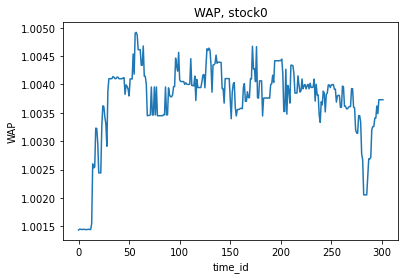

In [43]:
dfBook['WAP'] = (dfBook.bid_price1*dfBook.ask_size1+dfBook.ask_price1*dfBook.bid_size1)/(dfBook.bid_size1+dfBook.ask_size1)
display(dfBook.head())
plt.plot(dfBook['WAP']);plt.xlabel('time_id');plt.ylabel('WAP');plt.title('WAP, stock0');plt.show()

## Compute Log returns
Use to compare stock between yesterday and today but price differences are not always comparable across stocks

Calling  $S_{t}$  the price of the stock  S  at time  t , we can define the log return between  t1  and  t2  as:

$r_{t_1, t_2} = \log \left( \frac{S_{t_2}}{S_{t_1}} \right)$

Log returns present several advantages, for example:

1) they are additive across time  $r_{t_1,t_2}$+$r_{t_2,t_3}$=$r_{t_1,t_3}$ 
2) regular returns cannot go below -100%, while log returns are not bounded

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,WAP,logReturn
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100,1.001434,NaN
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100,1.001448,0.000014
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100,1.001448,0.000000
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100,1.001443,-0.000005
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100,1.001443,0.000000


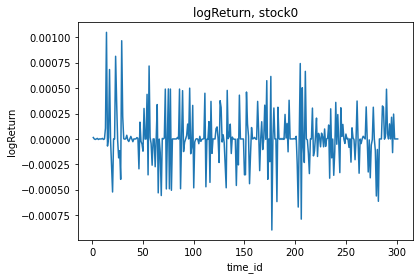

In [44]:
dfBook['logReturn'] = np.log(dfBook['WAP']).diff() 
display(dfBook.head())
plt.plot(dfBook['logReturn']);plt.xlabel('time_id');plt.ylabel('logReturn');plt.title('logReturn, stock0');plt.show()

## Realized volatility
When we trade options, a valuable input to our models is the standard deviation of the stock log returns. Usually normalized to a 1-year period and the annualized standard deviation is called volatility.
In this competition, you will be given 10 minutes of book data and we ask you to predict what the volatility will be in the following 10 minutes. Volatility will be measured as follows:

$\sigma = \sqrt{\sum_{t}r_{t-1, t}^2}$

$\sigma$ = realized volatility

Where we use WAP as price of the stock to compute log returns.

In [46]:
realized_vol= np.sqrt(np.sum(dfBook.logReturn**2))
print(f'Realized Volatility of stock id={stock_id} & time id={time_id}: {realized_vol}')

Realized Volatility of stock id=0 & time id=5: 0.004499364172786559


# bid/ask spread

As different stocks trade on different level on the market we take the ratio of best offer price and best bid price to calculate the bid-ask spread.

The formula of bid/ask spread can be written in below form:

$BidAskSpread=BestOffer/BestBid−1$

# Competition Data
Generate a series of short-term signals from the book and trade data of a fixed 10-minute window to predict the realized volatility of the next 10-minute window. 

The target, which is given in train/test.csv, can be linked with the raw order book/trade data by the same time_id and stock_id. There is no overlap between the feature and target window.

In [48]:
# Investigate each .csv file
path = 'C:/Users/Darkblade/Documents/Kaggle/dataset/OptiverPrediction/'
ls = glob.glob(path+'/*.csv')
for l in ls:
    print(l.split('\\')[-1])
    display(pd.read_csv(l))

sample_submission.csv


,row_id,target
0,0-4,0.003048
1,0-32,0.003048
2,0-34,0.003048


test.csv


,stock_id,time_id,row_id
0,0,4,0-4
1,0,32,0-32
2,0,34,0-34


train.csv


,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747
...,...,...,...
428927,126,32751,0.003461
428928,126,32753,0.003113
428929,126,32758,0.004070
428930,126,32763,0.003357


## Reference: Example from Kaggle, assume initial realize_vol as prediction value

In [4]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 

def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

def realized_volatility_per_time_id(file_path, prediction_column_name):
    df_book_data = pd.read_parquet(file_path)
    df_book_data['wap'] =(df_book_data['bid_price1'] * df_book_data['ask_size1']+df_book_data['ask_price1'] * df_book_data['bid_size1'])  / (
                                      df_book_data['bid_size1']+ df_book_data[
                                  'ask_size1'])
    df_book_data['log_return'] = df_book_data.groupby(['time_id'])['wap'].apply(log_return)
    df_book_data = df_book_data[~df_book_data['log_return'].isnull()]
    df_realized_vol_per_stock =  pd.DataFrame(df_book_data.groupby(['time_id'])['log_return'].agg(realized_volatility)).reset_index()
    df_realized_vol_per_stock = df_realized_vol_per_stock.rename(columns = {'log_return':prediction_column_name})
    stock_id = file_path.split('=')[1].split('\\')[0]
    df_realized_vol_per_stock['row_id'] = df_realized_vol_per_stock['time_id'].apply(lambda x:f'{stock_id}-{x}')
    return df_realized_vol_per_stock[['row_id',prediction_column_name]]
realized_volatility_per_time_id(book_path[0], 'pred')

,row_id,pred
0,0-5,0.004499
1,0-11,0.001204
2,0-16,0.002369
3,0-31,0.002574
4,0-62,0.001894
...,...,...
3825,0-32751,0.002579
3826,0-32753,0.002206
3827,0-32758,0.002913
3828,0-32763,0.003046


In [5]:
list_order_book_file_train = glob.glob(f'{root}/book_train.parquet/*')
list_order_book_file_train = [l.replace('\\','/') for l in list_order_book_file_train]
list_order_book_file_train = [l.replace('//','/') for l in list_order_book_file_train]

In [6]:
def past_realized_volatility_per_stock(list_file,prediction_column_name):
    df_past_realized = pd.DataFrame()
    for file in list_file:
        df_past_realized = pd.concat([df_past_realized,
                                     realized_volatility_per_time_id(file,prediction_column_name)])
    return df_past_realized
df_past_realized_train = past_realized_volatility_per_stock(list_file=list_order_book_file_train,prediction_column_name='pred')

In [7]:
from sklearn.metrics import r2_score
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))
R2 = round(r2_score(y_true = df_joined['target'], y_pred = df_joined['pred']),3)
RMSPE = round(rmspe(y_true = df_joined['target'], y_pred = df_joined['pred']),3)
print(f'Performance of the naive prediction: R2 score: {R2}, RMSPE: {RMSPE}')

NameError: name 'df_joined' is not defined